# Бизнес задача

Имеется датасет с данными о транзакциях, совершённых в магазине. Датасет содержит 20 столбцов и 7501 строк.

**Необходимо** проанализировать датасет с применением алгоритмов машинного обучения, работающих с ассоциативными правилами. Обнаружить наборы продуктов, которые часто покупают вместе, с целью получить возможность более грамотно расположить продукты в магазине, увеличив число их покупок

# Подготовка данных

Загрузка датасета

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving Basket.csv to Basket.csv


Представим датасет в виде массива строк

In [ ]:
import csv

data_list = []
with open("Basket.csv") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        data_list.append(row)

Библотека mlxtend

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Сформируем список товаров

In [ ]:
te = TransactionEncoder()
te.fit(data_list)

print("Список товаров: {}".format(te.columns_))
print("Всего различных товаров: {}".format(len(te.columns_)))

Список товаров: [' asparagus', 'almonds', 'antioxydant juice', 'asparagus', 'avocado', 'babies food', 'bacon', 'barbecue sauce', 'black tea', 'blueberries', 'body spray', 'bramble', 'brownies', 'bug spray', 'burger sauce', 'burgers', 'butter', 'cake', 'candy bars', 'carrots', 'cauliflower', 'cereals', 'champagne', 'chicken', 'chili', 'chocolate', 'chocolate bread', 'chutney', 'cider', 'clothes accessories', 'cookies', 'cooking oil', 'corn', 'cottage cheese', 'cream', 'dessert wine', 'eggplant', 'eggs', 'energy bar', 'energy drink', 'escalope', 'extra dark chocolate', 'flax seed', 'french fries', 'french wine', 'fresh bread', 'fresh tuna', 'fromage blanc', 'frozen smoothie', 'frozen vegetables', 'gluten free bar', 'grated cheese', 'green beans', 'green grapes', 'green tea', 'ground beef', 'gums', 'ham', 'hand protein bar', 'herb & pepper', 'honey', 'hot dogs', 'ketchup', 'light cream', 'light mayo', 'low fat yogurt', 'magazines', 'mashed potato', 'mayonnaise', 'meatballs', 'melons', 'mi

Представим датасет в виде Pandas DataFrame, где столбец - это один из 120 товаров

Преимущество работы с фреймами данных pandas заключается в том, что мы можем использовать его удобные функции для фильтрации результатов.

In [ ]:
import pandas as pd 

transactions_onehot = te.transform(data_list)

data = pd.DataFrame(transactions_onehot, columns=te.columns_)
data

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,bramble,brownies,bug spray,burger sauce,burgers,butter,cake,candy bars,carrots,cauliflower,cereals,champagne,chicken,chili,chocolate,chocolate bread,chutney,cider,clothes accessories,cookies,cooking oil,corn,cottage cheese,cream,dessert wine,eggplant,eggs,energy bar,energy drink,...,oil,olive oil,pancakes,parmesan cheese,pasta,pepper,pet food,pickles,protein bar,red wine,rice,salad,salmon,salt,sandwich,shallot,shampoo,shrimp,soda,soup,spaghetti,sparkling water,spinach,strawberries,strong cheese,tea,tomato juice,tomato sauce,tomatoes,toothpaste,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False

# Анализ датасета

Проанализируем частотность продуктов в датасете

In [ ]:
frequency_list = pd.DataFrame(data=data.sum(axis=0)).reset_index().rename(columns={'index': 'item', 0: 'frequency'}).sort_values(by=['frequency'],ascending=False)
frequency_list

,item,frequency
72,mineral water,1788
37,eggs,1348
100,spaghetti,1306
43,french fries,1282
25,chocolate,1229
...,...,...
11,bramble,14
34,cream,7
77,napkins,5
112,water spray,3


Основная статистика по частотности продуктов

In [ ]:
frequency_list.describe()

,frequency
count,120.000000
mean,244.650000
std,317.819373
min,1.000000
25%,56.750000
50%,117.500000
75%,269.500000
max,1788.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f24b820d0>]],
      dtype=object)

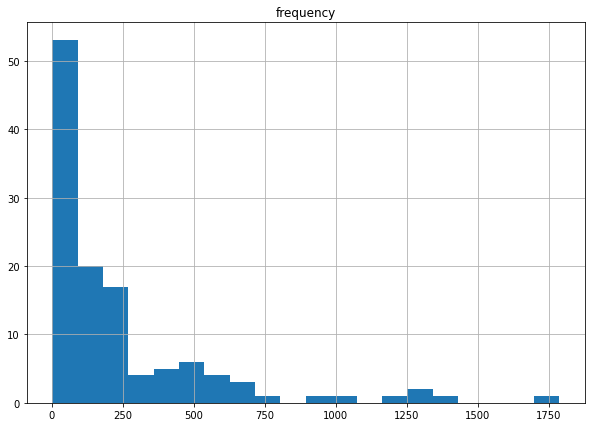

In [ ]:
frequency_list.hist(bins=20,figsize=(10,7))

**Вывод**

В датасете около 90 продуктов встречаются в транзакциях менее 250 раз. Очень мало продуктов с высокими частотами

# Как работают ассоциативные правила

**Ассоциативное правило** - закономерность A → B , где A и B - множества продуктов в корзине. Т.е. если клиент купил набор товаров A, то с высокой вероятностью он купит набор продуктов B.

**Метрики**:
* **Support правила** - доля чеков, в которых присутсвтует и продукт A, и продукт B - *устойчивость зависимости*. Т.е. как часто имеем возможность подобное правило наблюдать.

  support(A→B) = support(A∪B), range: [0,1]
* **Confidence правила** - доля тех, кто купил B, среди тех, кто купил A - *сила зависимости*. Однако Сonfidence может объясняться просто большой популярностью продукта B, а вовсе не его хорошими дополняющими свойствами к продукту A.

  confidence(A→B) = support(A→B) / support(A), range: [0,1]
* **Lift правила** - насколько Сonfidence правила выше/ниже общей популярности продукта B. Метрика Lift решает проблему метрки Confidence.
  
  lift(A→B) = confidence(A→B) / support(B), range: [0,∞]



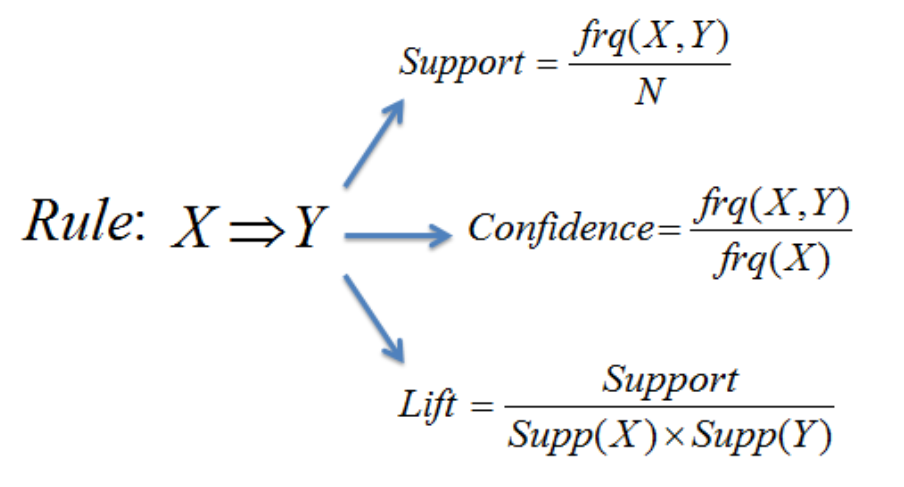

Существует множество алгоритмов, работающих с ассоциатвиными правилами. Рассмотрим два наиболее популярных: Apriory и fpgrowth

# Алгоритм Apriory

**Описание алгоритма**

Рассмотрим дерево префиксов, где 2 элемента X и Y соединены, если X является прямым подмножеством Y. Рисунок приведен ниже:

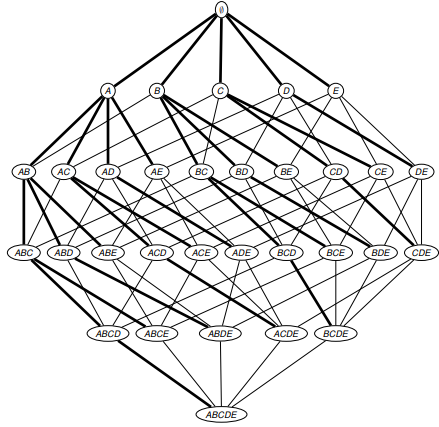

Apriori использует следующее утверждение: если $ X \subseteq Y$, то $support(X) \geq support(Y) $.

Отсюда следуют следующие 2 свойства:
* Если Y встречается часто, то любое подмножество $ X: X \subseteq Y $ так же встречается часто
* Если X встречается редко, то любое супермножество $ Y: Y \supseteq X $ так же встречается редко

Apriori алгоритм по-уровнево проходит по префиксному дереву и рассчитывает частоту встречаемости подмножеств X в D (датасет, содержащий список транзакций). Таким образом, в соответствии с алгоритмом:
* исключаются редкие подмножества и все их супермножества
* рассчитывается support(X) для каждого подходящего кандидата X размера k на уровне k

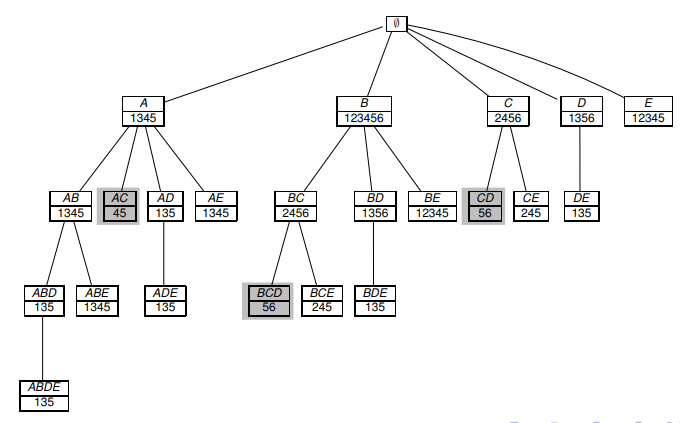

Явным минусом такого подхода является то, что необходимо «просканировать» весь датасет, посчитать все supp на всех уровнях breadth-first search (поиск в ширину)
Это также может подъесть RAM на больших датасетах, хотя алгоритм в плане скорости все равно намного эффективнее брутфорса.

**Подбор min_support**

После анализа частотности мы выяснили, что самый часто встречаемый продукт встречается 1788 раз. 

Верхняя граница min_support, начиная с которой в результате работы алгоритма будет появляться хотя бы одна запись: 1788/7501 = 0,238. 

Большая часть продуктов встречается менее 250 раз. Граница min_support: 250/7501 = 0.033. 

Более 50 продуктов имеют частоту появления меньше 80. Граница min_support 80/7501 = 0,01

**Вывод**

Нам нет смысла устанавливать слишком маленьким параметр min_support, так как тогда в формировании наших ассоциативных правил будт участвовать большое количество товаров с низкой частотой появления в транзакциях. Такие правила не будут показательны.


Однако в нашем датасете большая часть продуктов имеет низкую частоту, поэтому нам придётся их откиунть и использовать лишь малую часть продуктов. Но используя эту малую часть продуктов с высокой частотой появления в транзакциях мы можем выяснить реальные взаимосвязи между покупкой продуктов

Будем считать целесообразными для участия в формировании ассоциативных правил те товарыЮ частота появления которых выше 250. Поэтому за min_support возьмём 0,035

Найдем frequent itemsets

По умолчанию apriori возвращает индексы столбцов элементов. Для лучшей читабельности мы можем установить use_colnames=True, чтобы преобразовать эти целочисленные значения в соответствующие названия элементов:

In [ ]:
frequent_itemsets = apriori(data, min_support=0.035, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.087188,(burgers)
1,0.081056,(cake)
2,0.046794,(champagne)
3,0.059992,(chicken)
4,0.163845,(chocolate)
5,0.080389,(cookies)
6,0.051060,(cooking oil)
7,0.179709,(eggs)
8,0.079323,(escalope)
9,0.170911,(french fries)


Создадим правила ассоциации из часто используемых наборов элементов

In [ ]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(chocolate),(mineral water),0.163845,0.238368,0.052660,0.321400,1.348332,0.013604,1.122357
1,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,0.013007,1.218270
2,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401
3,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,0.022088,1.373997
4,(milk),(mineral water),0.129583,0.238368,0.047994,0.370370,1.553774,0.017105,1.209650
5,(spaghetti),(mineral water),0.174110,0.238368,0.059725,0.343032,1.439085,0.018223,1.159314


В результате наших исследований мы обнаружили, что почти во всех ассоциативных правилах в consequents находится mineral water. Это связано с тем, что mineral water имеет очень высокую частоту покупки. Именно она является самым частым товаром с частотой 1778. 

Воспользуемся метрикой lift, которая решает проблему confidence

In [ ]:
association_rules(frequent_itemsets, metric="lift", min_threshold=1.7)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401
1,(mineral water),(ground beef),0.238368,0.098254,0.040928,0.171700,1.747522,0.017507,1.088672
2,(spaghetti),(ground beef),0.174110,0.098254,0.039195,0.225115,2.291162,0.022088,1.163716
3,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,0.022088,1.373997


**Дополнительные метрики**:
* **Leverage** - вычисляет разницу между наблюдаемой частотой совместного появления A и B и частотой, которая ожидалась бы, если бы A и B были независимыми. Значение 0 указывает на независимость.

  levarage(A→B) = support(A→B) − support(A) × support(B), range: [−1,1]
* **Conviction** - высокое значение означает, что B сильно зависит от A. Например, в случае оценки абсолютной достоверности знаменатель становится 0 (из-за 1 - 1), для которого оценка убежденности определяется как "inf". Как и в случае с lift, если предметы независимы, conviction равно 1. Суть метрики - как соотносится популярность других товаров (не B) с частотой ситуации, когда правило не срабатывает.

  conviction(A→B) = (1 − support(B)) / (1−confidence(A→B)), range: [0,∞]

Рассмотрим, например, **ground beef -> spaghetti**:
* support=0.04 - в 4% чеков встречаются ground beef и spaghetti
* confidence=0.39 - в 39% тех, кто купил ground beef, также купили и spaghetti
* lift=2.29 - купившие ground beef покупают spaghetti на 129% чаще, чем все остальные покупатели
* conviction=1.37 - купившие ground beef покупают другие продукты на 37% реже, чем просто покупающие другие продукты (???)


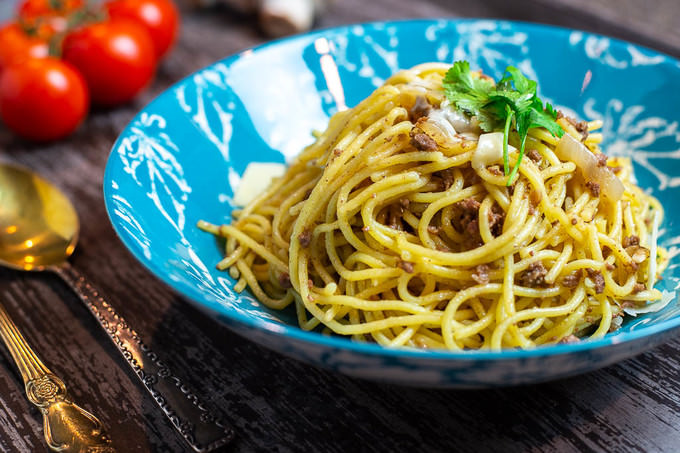

##Вывод

Входе анализа датасета мы получили следующий вывод:

Существует довольно неплохая связь между spaghetti и ground beef. 

Также существует несколько ассоциативных правил с довольно неплохими параметрами, однако в них в consequents стоит mineral water, которая является очень частой. Поэтому сложно сказать, что здесь дело в связи между продуктами,а не просто в высокой частоте mineral water.

Однако правило ground beef mineral water имеет самый высокий lift среди правил с mineral water

# Алгоритм Fpgrowth

Сущетсвует ещё один распространённый алгоритм для работы с ассоциативными правилами - FP-Growth

FP-Growth предлагает отказаться от генерации кандидатов (напомним, генерация кандидатов лежит в основе Apriori). Теоретически, такой подход позволит еще больше увеличить скорость алгоритма и использовать еще меньше памяти.

Это достигается за счет хранения в памяти префиксного дерева (trie) не из комбинаций кандидатов, а из самих транзакций.

При этом FP-Growth генерирует таблицу заголовков для каждого item, чей support выше заданного пользователем. Эта таблица заголовков хранит связанный список всех однотипных узлов префиксного дерева.


Попробуем применить его

In [ ]:
from mlxtend.frequent_patterns import fpgrowth
frequent_itemsets = fpgrowth(data, min_support=0.035, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.087188,(burgers)
1,0.081056,(cake)
2,0.046794,(champagne)
3,0.059992,(chicken)
4,0.163845,(chocolate)
5,0.080389,(cookies)
6,0.051060,(cooking oil)
7,0.179709,(eggs)
8,0.079323,(escalope)
9,0.170911,(french fries)


In [ ]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(chocolate),(mineral water),0.163845,0.238368,0.052660,0.321400,1.348332,0.013604,1.122357
1,(frozen vegetables),(mineral water),0.095321,0.238368,0.035729,0.374825,1.572463,0.013007,1.218270
2,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401
3,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,0.022088,1.373997
4,(milk),(mineral water),0.129583,0.238368,0.047994,0.370370,1.553774,0.017105,1.209650
5,(spaghetti),(mineral water),0.174110,0.238368,0.059725,0.343032,1.439085,0.018223,1.159314


In [ ]:
association_rules(frequent_itemsets, metric="lift", min_threshold=1.7)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ground beef),(mineral water),0.098254,0.238368,0.040928,0.416554,1.747522,0.017507,1.305401
1,(mineral water),(ground beef),0.238368,0.098254,0.040928,0.171700,1.747522,0.017507,1.088672
2,(spaghetti),(ground beef),0.174110,0.098254,0.039195,0.225115,2.291162,0.022088,1.163716
3,(ground beef),(spaghetti),0.098254,0.174110,0.039195,0.398915,2.291162,0.022088,1.373997


##Вывод

Все рассуждения проведённые для алгоритма Apriory справедливы и для Fpgrowth. Причём оба алгоритма выдают одинаковые результаты.

Возможно, их различие в эффективности поиска ассоциативных правил. Проверим это

# Apriori vs Fpgrowth

Apriori vs Fpgrowth
http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/

In [ ]:
%timeit -n 100 -r 5 apriori(data, min_support=0.01, use_colnames=True)

100 loops, best of 5: 265 ms per loop


In [ ]:
%timeit -n 100 -r 5 apriori(data, min_support=0.035, use_colnames=True)

100 loops, best of 5: 43.1 ms per loop


In [ ]:
%timeit -n 100 -r 5 fpgrowth(data, min_support=0.01, use_colnames=True)

In [ ]:
%timeit -n 100 -r 5 fpgrowth(data, min_support=0.035, use_colnames=True)

##Вывод

В нашем датасете при min_support=0.035 данных не очень много, ассоциативных правил не так много и они простые, поэтому алгортим apriory показывает себя существенно лучше. Однако при уменьшении min_support до 0.01 fpgrowth показывает себя лучше, так как данных становится больше и правила сложнее.

Таким образом, можно сказать, что fpgrowth показывает себя лучше на больших датасетах, а apriory может хорошо себя показть на маленьких, где не так много ассоциативных правил.

# Источники информации

1. https://habr.com/ru/company/ods/blog/353502/ - статья про ассоциативные правила
2. http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/ - описание алгоритма Apriori в библиотеке mlxtend
3. http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/ - генерация правил ассоциации из часто используемых наборов элементов в библиотеке mlxtend
4. http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/fpgrowth/ - описание алгоритма FP-Growth в библиотеке mlxtend
5. https://docs.python.org/3/library/timeit.html - описание timeit в документации Python